# Varying Noise Experiment
In this notebook, we test our algorithm in setting where there is a lot of noise variance. We then compare our results to other methods on the same task.

In [3]:
import sys 
sys.path.append('/Users/patroklos/Desktop/delphi_')
# sys.path.append('/Users/patroklos/Desktop/')

import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA

from torch.distributions import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.store import Store
from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 
import IPython 

from delphi.stats.truncated_linear_regression import TruncatedLinearRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata, Parameters

# commands and arguments
COMMAND = 'Rscript'
PATH2SCRIPT = './truncreg.R'
TMP_FILE = 'tmp.csv'
RESULT_FILE = 'result.csv'

# mean squared error loss
mse_loss = ch.nn.MSELoss()

In [4]:
args = Parameters({
    "samples": 50000, # number of samples to generate for ground-truth
    "c": 0, # left truncation parameter
    "bs": 10,
    "lr": 1e-1,
    'var_lr': 1e-2,
    "trials": 5,
    "x_lower": -5,  # lower bound for generating input features
    "x_upper": 5,  # upper bound for generating input features
    "lower": -1, # lower bound for generating ground-truth
    "upper": 1, # lower bound for generating ground-truth
#     'out_dir': '<FILL IN OUT_DIR HERE>' 
#     'out_dir': '/Users/patroklos/Desktop/Adam_Var20_20Trials', 
#     'out_dir': '/Users/patroklos/Desktop/exp/more_reasonable', 
    'out_dir': '/Users/patroklos/Desktop/exp/unknown_var', 


#     'exp': '<FILL IN EXP HERE>', 
#     'exp': 'checking_grad_bs_10', 
#     'exp': 'identity',
    'exp': 'checking_grad_bs_10_10d', 
    'exp': 'checking_grad_bs_10_10d_known_bs_1', 

    'exp': '10k_samples',
    'exp': '20D_10K',
    'exp': '20D_10K_known_batch_size_1',
    'exp': '100D_50K',
    'exp': '100D_50K_',

    'eps': 1e-2,
    'var': 10,  # maximum variance to use in procedure 
    'tol': 1e-1, 
    'bias': True, 
    'num_samples': 10, 
    'table_name': 'logs',
    'epochs': 5,
    'step_lr': 100,
    'num_trials': 1,
})

I will first begin, by showing how to use our algorithm in a 1 dimensional setting. I will sample input features from a Uniform distribution, I will also sample my ground-truth from a Uniform distribution, and I will add Gaussian noise with noise variance 10.

In [5]:
# distribution for generating feature vectors
d, k = 5, 1
w = Uniform(args.lower, args.upper)
m = Uniform(args.x_lower, args.x_upper)
phi = oracle.Left_Regression(Tensor([args.C]))
# phi = oracle.Identity()

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
    y = gt(X)
    
# normalize input features
l_inf = LA.norm(X, dim=-1, ord=float('inf')).max()
beta = l_inf * (X.size(1) ** .5)

X /= beta

noise_var = Tensor([1.0])[...,None]
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = y_trunc.size(0) / args.samples
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

if d == 1:
    # data for plotting regressions
    data = np.linspace(-1, 1, 100).reshape(100, 1)

    ax = plt.subplot(1, 1, 1)
    plt.scatter(X, noised)
    plt.scatter(x_trunc, y_trunc)
    plt.plot(data, gt_ols.predict(data), color='green', label='gt ols')
    plt.plot(data, trunc_ols.predict(data), color='red', label='trunc ols')
    plt.legend()
    plt.title("Empirical and Ground Truth Dataset and Model")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

gt weight:  Parameter containing:
tensor([[-0.1539,  0.8275,  0.5447, -0.2002, -0.6915]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[0.8442]], requires_grad=True)
alpha:  0.5879
gt ols coef:  [[-1.6966579  9.236328   6.073385  -2.216238  -7.7456646]]
gt ols intercept:  [0.84595776]
trunc ols coef:  [[-1.5606699  8.31274    5.514042  -2.0300004 -7.0036   ]]
trunc ols intercept:  [1.2416303]


We now observe that the norm of the truncated x covariates is bounded by 1. 

Now, we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

In [6]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_y_trunc = (y_trunc - trunc_ols.intercept_) / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

emp_stand_noised = (noised - trunc_ols.intercept_) / ch.sqrt(emp_noise_var)

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc, emp_stand_y_trunc)

if d == 1:
    ax = plt.subplot(1, 1, 1)
    plt.scatter(X, emp_stand_noised, label='entire dataset', alpha=.75)
    plt.scatter(x_trunc, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
    plt.plot(X, gt_emp_stand.predict(X), color='green', label='gt ols')
    plt.plot(X, trunc_emp_stand_ols.predict(X), color='red', label='trunc ols')
    plt.legend()
    plt.title('Y Scaled by Empirical Noise Variance')
    ax.set_xlabel("x")
    ax.set_ylabel("y")

emp noise var:  tensor([0.9059])
trunc reg noise var:  tensor([1.0000])


Now, we will standardize our data for the case where we assume that we know the underlying ground-truth noise variance.

In [7]:
stand_noised, stand_y_trunc = (noised - trunc_ols.intercept_) / ch.sqrt(noise_var), (y_trunc - trunc_ols.intercept_) / ch.sqrt(noise_var)

gt_stand = LinearRegression()
gt_stand.fit(X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(X)).var(0)
print("reg noise var: ", reg_noise_var)

if d == 1:
    ax = plt.subplot(1, 1, 1)
    plt.scatter(X, stand_noised, label='entire dataset', alpha=.75)
    plt.scatter(x_trunc, stand_y_trunc, label='truncated dataset', alpha=.75)
    plt.plot(X, gt_stand.predict(X), color='green', label='gt ols')
    plt.plot(X, trunc_stand_ols.predict(X), color='red', label='trunc ols')
    plt.legend()
    plt.title("Y Scaled by Ground-Truth Noise Variance")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

trunc reg noise var:  tensor([0.9059])
reg noise var:  tensor([0.9948])


We now run our procedure for truncated regression with known variance, assuming that we are given the ground-truth noise variance.

In [8]:
known_store = Store(args.out_dir + '/another_test_again')

Logging in: /Users/patroklos/Desktop/exp/unknown_var/another_test_again/10e9b5e9-c4db-44ef-9933-cd0872c05973


In [ ]:
y_trunc_scale = y_trunc / ch.sqrt(noise_var)
phi_scale = oracle.Left_Regression((phi.left - trunc_ols.intercept_) / ch.sqrt(noise_var))
train_kwargs = Parameters({'phi': phi_scale, 
                 'alpha': alpha, 
                    'noise_var': 1.0,
                    'batch_size': 1,
                    'epochs': 200, 
                    'trials': 1, 
                    'num_samples': 10,
                    'step_lr': 100,
#                     'adam': True,
                    'lr': 1e-1,
                    'normalize': False})
known_trunc_reg = TruncatedLinearRegression(train_kwargs, store=known_store)
known_trunc_reg.fit(x_trunc, stand_y_trunc)
w = known_trunc_reg.coef_ * ch.sqrt(noise_var)
w0 = known_trunc_reg.intercept_ * ch.sqrt(noise_var)

In [8]:
known_store.close()

In [9]:
reader = CollectionReader(args.out_dir + '/another_test')
logs = reader.df('logs')
reader.close()
logs.head()

100%|██████████| 3/3 [00:00<00:00, 113.04it/s]


,epoch,train_loss,train_prec1,train_prec5,val_loss,val_prec1,val_prec5,exp_id
0,1,0.032807,0.0,0.0,0.005418,0.0,0.0,f4336451-472f-442f-bc06-7e061f11fe24
1,2,0.032316,0.0,0.0,0.024185,0.0,0.0,f4336451-472f-442f-bc06-7e061f11fe24
2,3,0.035245,0.0,0.0,0.009808,0.0,0.0,f4336451-472f-442f-bc06-7e061f11fe24
3,4,0.030766,0.0,0.0,0.000419,0.0,0.0,f4336451-472f-442f-bc06-7e061f11fe24
4,5,0.040940,0.0,0.0,0.020601,0.0,0.0,f4336451-472f-442f-bc06-7e061f11fe24


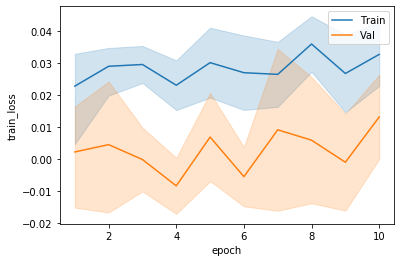

In [10]:
sns.lineplot(data=logs, x='epoch', y='train_loss', label='Train')
sns.lineplot(data=logs, x='epoch', y='val_loss', label='Val')
plt.legend()

In [11]:
gt_ = ch.from_numpy(np.concatenate([gt_ols.coef_, gt_ols.intercept_.reshape(-1, 1)], axis=1))

In [12]:
ch.sqrt(mse_loss(ch.cat([w, w0], dim=1), gt_))

tensor(0.6196)

In [13]:
trunc_  = ch.from_numpy(np.concatenate([trunc_ols.coef_, trunc_ols.intercept_.reshape(-1, 1)], axis=1))

In [14]:
ch.sqrt(mse_loss(trunc_, gt_))

tensor(0.7528)

In [15]:
if d == 1:
    ax = plt.subplot(1, 1, 1)
    plt.scatter(X, noised, label='entire dataset', alpha=.75)
    plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
    plt.plot(X, trunc_ols.predict(X), color='r', label='ols')
    plt.plot(X, gt_ols.predict(X), color='green', label='gt')
    plt.plot(X, (X@w + w0).numpy(), label='known', color='blue')
    plt.legend()
    plt.title("Known Noise Variance - UnNormalized")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.show()
else: 
    pass

In [16]:
trunc_ols_w = ch.from_numpy(trunc_ols.coef_)

In [17]:
rand_w = ch.rand(w.size(1), 2)

In [18]:
w_new = w @ rand_w
ols_w_new = trunc_ols_w @ rand_w
x_new = X @ rand_w
gt_w_new = ch.from_numpy(gt_ols.coef_)@ rand_w

In [19]:
x_pred = ch.linspace(x_new[:,0].min(), x_new[:,0].max(), 30)
y_pred = ch.linspace(x_new[:,1].min(), x_new[:,1].max(), 30)
xx_pred, yy_pred = ch.meshgrid(x_pred, y_pred)
model_viz = ch.stack([xx_pred.flatten(), yy_pred.flatten()]).T

/opt/anaconda3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [20]:
known_trunc_pred = w_new @ model_viz.T + w0
ols_trunc_pred = ols_w_new @ model_viz.T + trunc_ols.intercept_
gt_pred = gt_w_new @ model_viz.T + gt_ols.intercept_

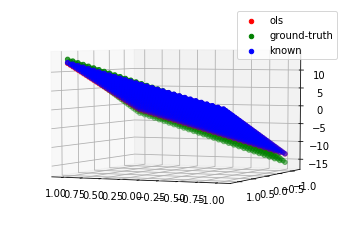

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(xx_pred.flatten(), yy_pred.flatten(), ols_trunc_pred, color='red', label='ols')
ax.scatter(xx_pred.flatten(), yy_pred.flatten(), gt_pred, color='green', label='ground-truth')
ax.scatter(xx_pred.flatten(), yy_pred.flatten(), known_trunc_pred, color='blue', label='known')

ax.legend()
# ax.view_init(elev=28, azim=120)
ax.view_init(elev=4, azim=114)

Truncated Regression with Unknown Noise Variance

In [22]:
y_trunc_emp_scale = y_trunc / ch.sqrt(emp_noise_var)
# phi_emp_scale = oracle.Left_Regression(phi.left / ch.sqrt(emp_noise_var))
train_kwargs = Parameters({'phi': phi, 
                   'alpha': alpha,
                    'epochs': 5, 
                    'trials': 1, 
                  'batch_size': 10, 
#                  'early_stopping': True, 
                 'var_lr': 1e-2, 
                    'step_lr': 1000,
                    'normalize': False,
                  'fit_intercept': True})
unknown_trunc_reg = TruncatedLinearRegression(train_kwargs)
unknown_trunc_reg.fit(x_trunc, y_trunc_emp_scale)
w = unknown_trunc_reg.coef_*ch.sqrt(emp_noise_var)
w0 = unknown_trunc_reg.intercept_*ch.sqrt(emp_noise_var)

In [28]:
ch.sqrt(mse_loss(ch.cat([w, w0[...,None]], dim=1), gt_))

tensor(0.6252)

In [30]:
# spawn subprocess to run truncreg experiment
concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
"""
DATA FORMAT:
    -First n-1 columns are independent variables
    -nth column is dependent variable
"""
concat_df = pd.DataFrame(concat)
concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
"""
Arguments
- c - truncation point (float)
- dir - left or right -> type of truncation (str)
"""
cmd = [COMMAND, PATH2SCRIPT] + [str(0), str(d), 'left', args.out_dir]

# check_output will run the command and store the result
st = datetime.datetime.now()
result = subprocess.check_output(cmd, universal_newlines=True)
total_time = int((datetime.datetime.now() - st).total_seconds())
trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]

In [33]:
ch.sqrt(mse_loss(trunc_reg_params, gt_))

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 6])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1077)

ValueError: x and y must be the same size

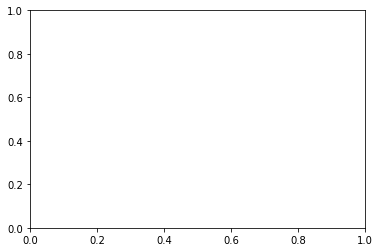

In [29]:
ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(X, trunc_ols.predict(X), label='ols', color='red')
plt.plot(X, gt_ols.predict(X), color='g', label='gt')
plt.plot(X, (X@w + w0).numpy(), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Generate Ground-Truth and Run Experiment

In [48]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 100, 1
# distribution for generating feature vectors
W = Uniform(w_lower, w_upper)
dist = Uniform(-5, 5)
phi = oracle.Left_Regression(0.0)
# phi = oracle.Identity()

    
def gen_ground_truth(): 
    # generate ground truth
    gt = ch.nn.Linear(in_features=d, out_features=k)
    gt.weight = ch.nn.Parameter(W.sample(ch.Size([k, d])))
    gt.bias = ch.nn.Parameter(W.sample(ch.Size([1, 1]))) if args.bias else None

    # create base classifier
    with ch.no_grad():
        # generate data
        X = dist.sample(ch.Size([args.samples, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([args.samples]))
        y = gt(X)
        
    return X, y

In [57]:
# create store and add table
store = Store(args.out_dir + '/' + args.exp)
store.add_table(args.table_name, { 
    'ols_r2': float,
    'ols_param_mse': float,
    'ols_var_l1': float,
    'known_r2': float,
    'known_param_mse': float,
    'known_time': int,
    'unknown_r2': float, 
    'unknown_param_mse': float,
    'unknown_var_l1': float,
    'unknown_time': int,
    'trunc_reg_r2': float,
    'trunc_reg_param_mse': float, 
    'trunc_reg_var_mse': float,
    'trunc_reg_time': int,
    'alpha': float, 
    'num_samples': int,
    'noise_var': float, 
})


for i in range(args.trials):
    # generate ground truth
    X, y = gen_ground_truth()
    
    for noise_var in range(1, args.var + 1): 
        noise_var = Tensor([noise_var])[None,...]
        # add noise to ground-truth pedictions
        noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
        # truncate based off of the standardized data
        indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = y_trunc.size(0) / args.samples
        # mean for dependent variable
        y_trunc_mu = y_trunc.mean(0)
        
        # normalize input features
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
        beta = l_inf * (x_trunc.size(1) ** .5)

        X /= beta
        x_trunc /= beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        gt_var = (noised - gt_ols.predict(X)).var(0)
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = (y_trunc - ols.predict(x_trunc)).var(0)
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[args.table_name].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - gt_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
                
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = (y_trunc - y_trunc_mu) / ch.sqrt(ols_var)
        # standardize noised by the empirical noise variance
        emp_stand_noised = noised / ch.sqrt(ols_var)
        
        emp_stand_phi = oracle.Left_Regression((phi.left - y_trunc_mu) / ch.sqrt(ols_var))

        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by actual noise variance
        stand_y_trunc = (y_trunc - y_trunc_mu) / ch.sqrt(noise_var)
        # standardize noised by actual noise variance
        stand_phi = oracle.Left_Regression((phi.left - y_trunc_mu) / ch.sqrt(noise_var))

        st = datetime.datetime.now() 
        train_kwargs = Parameters({'phi': stand_phi, 
                                 'alpha': alpha,
                                'noise_var': 1.0,
                                'batch_size': 100,
                                'epochs': 10, 
                                'trials': 1, 
                                'normalize': False})
        known_trunc_reg = TruncatedLinearRegression(train_kwargs)
        known_trunc_reg.fit(x_trunc, stand_y_trunc)    
        total_time = int((datetime.datetime.now() - st).total_seconds())
        w, w0 = (known_trunc_reg.coef_ * ch.sqrt(noise_var)), known_trunc_reg.intercept_[..., None] * ch.sqrt(noise_var) + y_trunc_mu
        known_params = ch.cat([w, w0], dim=1).flatten()
        
        # known results
        store[args.table_name].update_row({
            'known_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'known_param_mse': mse_loss(gt_params, known_params),
            'known_time': total_time, 
        })

        st = datetime.datetime.now()     
        train_kwargs = Parameters({'phi': emp_stand_phi, 
                      'alpha': alpha,
                        'var_lr': 1e-2,
                        'batch_size': 100,
                        'epochs': 10, 
                        'trials': 1, 
                        'num_samples': 100,
                         'normalize': False})
        unknown_trunc_reg = TruncatedLinearRegression(train_kwargs)
        unknown_trunc_reg.fit(x_trunc, emp_stand_y_trunc)
        total_time = int((datetime.datetime.now() - st).total_seconds())

        unknown_var = unknown_trunc_reg.variance * ols_var
        w, w0 = (unknown_trunc_reg.coef_ * ch.sqrt(ols_var)), unknown_trunc_reg.intercept_ * ch.sqrt(ols_var) + y_trunc_mu
        unknown_params = ch.cat([w, w0[None,...]], dim=1).flatten()
        
                
        # known emp results
        store[args.table_name].update_row({
            'unknown_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'unknown_param_mse': mse_loss(gt_params, unknown_params),
            'unknown_var_l1': float(ch.abs(unknown_var - gt_var)),
            'unknown_time': total_time, 
        })
            
            
        # spawn subprocess to run truncreg experiment
        concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
        """
        DATA FORMAT:
            -First n-1 columns are independent variables
            -nth column is dependent variable
        """
        concat_df = pd.DataFrame(concat)
        concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
        """
        Arguments
        - c - truncation point (float)
        - dir - left or right -> type of truncation (str)
        """
        cmd = [COMMAND, PATH2SCRIPT] + [str(0), str(d), 'left', args.out_dir]

        # check_output will run the command and store the result
        st = datetime.datetime.now()
        result = subprocess.check_output(cmd, universal_newlines=True)
        total_time = int((datetime.datetime.now() - st).total_seconds())
        trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
        trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

        trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]
        
        # truncreg results
        store[args.table_name].update_row({
            'trunc_reg_r2': r2_score(noised.flatten(), trunc_reg_pred.flatten()), 
            'trunc_reg_param_mse': mse_loss(trunc_reg_params, gt_params),
            'trunc_reg_var_mse': float(ch.abs(trunc_res[-1].pow(2)[None,...] - gt_var)),
            'trunc_reg_time': total_time, 
        })
        
        # add additional exp data to store
        store[args.table_name].update_row({ 
            'alpha': alpha,
            'num_samples': x_trunc.size(0),
            'noise_var': noise_var, 
        })

        # append row to table
        store[args.table_name].flush_row()
        
        IPython.display.clear_output()

store.close()    

In [58]:
reader = CollectionReader(args.out_dir + '/' + args.exp)
logs = reader.df(args.table_name)
# poor_results = reader.df('poor_results')
reader.close()
logs.head(10)

100%|██████████| 1/1 [00:00<00:00, 75.71it/s]


,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,trunc_reg_r2,trunc_reg_param_mse,trunc_reg_var_mse,trunc_reg_time,alpha,num_samples,noise_var,exp_id
0,0.905274,0.336657,0.097906,0.922167,0.100971,2,0.926652,0.001637,0.094403,10,0.926755,0.000208,0.007423,2,0.57346,28673,1.0,5cf6e460-0eb7-434f-ac4c-612555511763
1,0.803082,1.013073,0.318880,0.858697,0.143493,3,0.865034,0.000427,0.168883,11,0.865065,0.000244,0.005285,1,0.57202,28601,2.0,5cf6e460-0eb7-434f-ac4c-612555511763
2,0.705571,1.762968,0.619924,0.802745,0.180964,2,0.809885,0.000858,0.248474,9,0.809988,0.000678,0.030819,1,0.57160,28580,3.0,5cf6e460-0eb7-434f-ac4c-612555511763
3,0.613947,2.555630,1.025489,0.753567,0.204675,2,0.761070,0.007850,0.279220,10,0.761540,0.001442,0.013542,1,0.56904,28452,4.0,5cf6e460-0eb7-434f-ac4c-612555511763
4,0.527195,3.380529,1.428580,0.707190,0.246009,2,0.716103,0.004696,0.422324,10,0.716655,0.000643,0.053248,1,0.56644,28322,5.0,5cf6e460-0eb7-434f-ac4c-612555511763
5,0.469702,3.949734,1.848119,0.676416,0.254993,2,0.685040,0.004429,0.252910,9,0.685119,0.000930,0.025168,1,0.56552,28276,6.0,5cf6e460-0eb7-434f-ac4c-612555511763
6,0.396495,4.720253,2.317629,0.637520,0.275878,2,0.646933,0.004690,0.552045,9,0.647471,0.000378,0.112305,1,0.56442,28221,7.0,5cf6e460-0eb7-434f-ac4c-612555511763
7,0.334137,5.264216,2.879313,0.604072,0.270224,2,0.611741,0.012316,0.358185,9,0.612267,0.003419,0.059824,1,0.56510,28255,8.0,5cf6e460-0eb7-434f-ac4c-612555511763
8,0.301316,5.615133,3.371822,0.584501,0.220113,2,0.588727,0.037618,0.544242,9,0.590096,0.007834,0.081144,1,0.56270,28135,9.0,5cf6e460-0eb7-434f-ac4c-612555511763
9,0.245618,6.209949,3.994150,0.553108,0.307099,2,0.562139,0.010464,0.105105,9,0.561857,0.008197,0.188725,1,0.55894,27947,10.0,5cf6e460-0eb7-434f-ac4c-612555511763


In [59]:
logs['unknown_epsilon'] = logs['unknown_param_mse'] + logs['unknown_var_l1']
logs['trunc_reg_epsilon'] = logs['trunc_reg_param_mse'] + logs['trunc_reg_var_mse']
logs['ols_epsilon'] = logs['ols_param_mse'] + logs['ols_var_l1']

In [60]:
logs['unknown_param_mse'] = logs['unknown_param_mse'] **(1/2)
logs['known_param_mse'] = logs['known_param_mse'] **(1/2)
logs['ols_param_mse'] = logs['ols_param_mse'] **(1/2)
# known_emp_logs['known_emp_param_mse'] = known_emp_logs['known_emp_param_mse'] **(1/2)
logs['trunc_reg_param_mse'] = logs['trunc_reg_param_mse'] **(1/2)

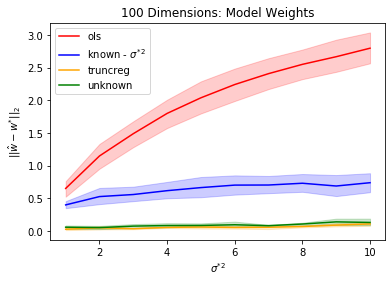

Text(0.5, 1.0, '100 Dimensions : Variance')

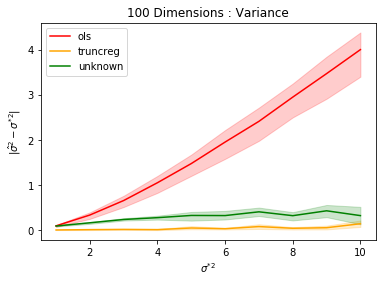

In [62]:
sns.lineplot(data=logs, x='noise_var', y='ols_param_mse', label='ols', color='r')
# sns.lineplot(data=known_emp_logs, x='noise_var', y='known_emp_param_mse', color='purple', label='known - $\sigma_{0}^{2}$')
sns.lineplot(data=logs, x='noise_var', y='known_param_mse', label='known - $\sigma^{*2}$', color='blue')
sns.lineplot(data=logs, x='noise_var', y='trunc_reg_param_mse', label='truncreg', color='orange')
ax = sns.lineplot(data=logs, x='noise_var', y='unknown_param_mse', label='unknown', color='green')

ax.set(xlabel='$\sigma^{*2}$', ylabel='$||\hat w - w^{*}||_{2}$')
ax.set_title(args.exp + " : Model Weights")
ax.set_title("100 Dimensions: Model Weights")

plt.show()

sns.lineplot(data=logs, x='noise_var', y='ols_var_l1', label='ols', color='red')
sns.lineplot(data=logs, x='noise_var', y='trunc_reg_var_mse', label='truncreg', color='orange')
ax = sns.lineplot(data=logs, x='noise_var', y='unknown_var_l1', label='unknown', color='green')
ax.set(xlabel='$\sigma^{*2}$', ylabel='$|\hat \sigma^{2} - \sigma^{*2}|$')
ax.set_title("100 Dimensions : Variance")

In [46]:
alpha = 5.0 
lower_p = (alpha / 2.0) / 100
upper_p = ((100 - alpha) + (alpha / 2.0)) / 100


trunc_reg_w_scores, trunc_reg_var_scores = [], [] 
unknown_w_score, unknown_var_scores = [], []
known_scores = []
ols_scores = {}
for var in range(1, args.var + 1):
    trunc_reg_w_scores, trunc_reg_var_scores = [], [] 
    unknown_w_score, unknown_var_scores = [], []
    known_scores = []
    ols_w_scores, ols_var_scores = [], []
    temp_logs = logs[logs.noise_var == var]

    for i in range(100):
#         # bootstrap sample
#         indices = randint(0, args.trials, args.trials)
        ols_w_scores.append(temp_logs.ols_param_mse.reset_index().loc[list(ch.randint(args.trials, (args.trials,)))].ols_param_mse.mean())
        ols_var_scores.append(temp_logs.ols_var_l1.reset_index().loc[list(ch.randint(args.trials, (args.trials,)))].ols_var_l1.mean())
        
        
#         trunc_reg_w_scores.append()
#         break
    ols_w_scores, ols_var_scores = Tensor(ols_w_scores), Tensor(ols_var_scores)
    w_median = ols_w_scores.median()
    var_median = ols_var_scores.median()
    # calculate 95% confidence interval (100 - alpha)
    w_lower, w_upper = ch.quantile(ols_w_scores, lower_p), ch.quantile(ols_w_scores, upper_p)
    var_lower, var_upper = ch.quantile(ols_var_scores, lower_p), ch.quantile(ols_var_scores, upper_p)
    ols_scores['w_' + str(var)] = (float(w_median), float(w_lower), float(w_upper))
    ols_scores['var_' + str(var)] = (float(var_median), float(var_lower), float(var_upper))

In [174]:
temp_logs.ols_param_mse.reset_index().loc[list(ch.randint(args.trials, (args.trials,)))].ols_param_mse

6     3.030272
6     3.030272
19    3.223487
15    2.931073
2     3.547897
9     3.126174
16    3.001810
0     2.873226
4     2.735724
7     3.405046
2     3.547897
5     2.645933
2     3.547897
0     2.873226
9     3.126174
11    3.054120
16    3.001810
1     3.001408
12    2.722246
0     2.873226
Name: ols_param_mse, dtype: float64

In [77]:
ols_params, gt_params

(tensor([ 14.7640,  -8.7930,  -0.6456,  -1.4492,   9.8987, -12.2191,  -6.0607,
         -10.0656,   0.3224,  12.2131,   0.4597]),
 tensor([ 14.7640,  -8.7930,  -0.6456,  -1.4492,   9.8987, -12.2191,  -6.0607,
         -10.0656,   0.3224,  12.2131,   0.4597]))

In [167]:
alpha = 5.0 
ols_ = {}
for key in ols_scores.keys():
    median = ols_scores[key].mean()
    # calculate 95% confidence interval (100 - alpha)
    lower_p = alpha / 2.0
    lower = ch.quantile(ols_scores[key], lower_p / 100)
    upper_p = (100 - alpha) + (alpha / 2.0)
    upper = ch.quantile(ols_scores[key], upper_p / 100)

In [168]:
median, lower, upper

(tensor(2.6757), tensor(2.5450), tensor(2.8050))

tensor(2.8050)

In [74]:
import torch.linalg as LA
l_inf = LA.norm(X, dim=-1, ord=float('inf')).max()
beta = l_inf * X.size(1) ** (.5)

In [75]:
x_norm = X / beta

In [76]:
gt_norm = LinearRegression()
gt_norm.fit(x_norm, y)

LinearRegression()

In [66]:
mse_loss(gt_params, ols_params)

tensor(10.9179)

In [67]:
mse_loss(gt_params, unknown_params)

tensor(4.6358)

In [68]:
mse_loss(gt_params, trunc_reg_params)

tensor(0.6809)

In [69]:
unknown_var

tensor([[7.6996]])

In [18]:
known_params

tensor([  3.9563,  -2.1333,  14.2551,   3.8213,  15.4614,   4.9579,  -9.0674,
         -2.0776, -22.9507,   1.7435, -15.0486, -12.5794, -10.7078,   5.4796,
        -12.4827, -18.2917,   7.3877,  -1.8538,  12.7872,  28.2893,   7.2695,
        -23.4611,   4.1070,  -7.8159, -26.8121,  -4.9069,   3.9623, -19.8507,
         18.4712,  21.4679, -16.2436,  13.5543,   7.7817,   7.9466,  19.6852,
        -11.2978,  -5.4686,  27.9285, -25.3441, -11.0517, -12.0706,  18.5779,
        -17.0258,  10.5283,  17.4846, -21.7057,   1.7203, -18.1620, -24.4898,
        -17.9561,   0.1242])

In [19]:
gt_params

tensor([ 5.9634e+00, -2.0752e+00,  1.8667e+01,  4.8233e+00,  1.9721e+01,
         7.3837e+00, -8.8153e+00, -5.0976e+00, -2.9605e+01,  4.1421e+00,
        -1.6852e+01, -1.6086e+01, -1.0001e+01,  7.1236e+00, -1.5981e+01,
        -2.2199e+01,  9.3080e+00, -1.1664e-01,  1.7001e+01,  3.3980e+01,
         9.7936e+00, -2.6875e+01,  3.2644e+00, -8.8556e+00, -3.2118e+01,
        -7.0600e+00,  5.2906e+00, -2.4072e+01,  2.5453e+01,  2.3790e+01,
        -1.9619e+01,  1.6363e+01,  1.2499e+01,  9.4148e+00,  2.3510e+01,
        -1.5088e+01, -6.0113e+00,  3.4654e+01, -3.0869e+01, -1.3696e+01,
        -1.4208e+01,  2.3122e+01, -1.8836e+01,  1.0621e+01,  2.2132e+01,
        -2.8544e+01,  1.3559e+00, -2.0967e+01, -3.0735e+01, -2.4453e+01,
         1.5681e-02])

In [20]:
w, w0 = (known_trunc_reg.coef_ * noise_var), known_trunc_reg.intercept_[..., None] * noise_var + y_trunc_mu
tmp_known_params = ch.cat([w, w0], dim=1).flatten()


In [23]:
mse_loss(gt_params, known_params)

tensor(13.3135)

In [61]:
tmp.sort(dim=1).indices

tensor([[0, 1, 6, 3, 5, 4, 2],
        [0, 1, 2, 6, 5, 4, 3]])

In [26]:
ols_ = LinearRegression().fit(x_trunc, stand_y_trunc)

In [27]:
(stand_y_trunc - ols_.predict(x_trunc)).var()

tensor(0.8968)

In [28]:
(stand_y_trunc - known_trunc_reg.predict(x_trunc)).var()

tensor(0.9444)

In [35]:
w_, w0_ = (known_trunc_reg.coef_ * ch.sqrt(noise_var)), known_trunc_reg.intercept_[..., None] * ch.sqrt(noise_var) + y_trunc_mu

In [36]:
x_trunc.size(), w_.size()

(torch.Size([5061, 50]), torch.Size([1, 50]))

In [37]:
trunc_pred = x_trunc@w_.T + w0_

In [38]:
(y_trunc - trunc_pred).var()

tensor(9.4439)

In [40]:
(y_trunc - ols.predict(x_trunc)).var()

tensor(8.9684)

In [46]:
(y_trunc - gt_ols.predict(x_trunc)).var()

tensor(9.8498)

In [53]:
from torch.nn import CosineSimilarity
cos_sim = CosineSimilarity()
cos_sim(known_params[None,...], gt_params[None,...])

tensor([0.9970])

In [57]:
cos_sim(ols_params[None,...], gt_params[None,...])

tensor([0.9996])

In [58]:
mse_loss(ols_params[None,...], gt_params[None,...])

tensor(6.3956)

In [59]:
mse_loss(known_params[None,...], gt_params[None,...])

tensor(13.3135)

In [60]:
known_params

tensor([  3.9563,  -2.1333,  14.2551,   3.8213,  15.4614,   4.9579,  -9.0674,
         -2.0776, -22.9507,   1.7435, -15.0486, -12.5794, -10.7078,   5.4796,
        -12.4827, -18.2917,   7.3877,  -1.8538,  12.7872,  28.2893,   7.2695,
        -23.4611,   4.1070,  -7.8159, -26.8121,  -4.9069,   3.9623, -19.8507,
         18.4712,  21.4679, -16.2436,  13.5543,   7.7817,   7.9466,  19.6852,
        -11.2978,  -5.4686,  27.9285, -25.3441, -11.0517, -12.0706,  18.5779,
        -17.0258,  10.5283,  17.4846, -21.7057,   1.7203, -18.1620, -24.4898,
        -17.9561,   0.1242])

In [61]:
gt_params

tensor([ 5.9634e+00, -2.0752e+00,  1.8667e+01,  4.8233e+00,  1.9721e+01,
         7.3837e+00, -8.8153e+00, -5.0976e+00, -2.9605e+01,  4.1421e+00,
        -1.6852e+01, -1.6086e+01, -1.0001e+01,  7.1236e+00, -1.5981e+01,
        -2.2199e+01,  9.3080e+00, -1.1664e-01,  1.7001e+01,  3.3980e+01,
         9.7936e+00, -2.6875e+01,  3.2644e+00, -8.8556e+00, -3.2118e+01,
        -7.0600e+00,  5.2906e+00, -2.4072e+01,  2.5453e+01,  2.3790e+01,
        -1.9619e+01,  1.6363e+01,  1.2499e+01,  9.4148e+00,  2.3510e+01,
        -1.5088e+01, -6.0113e+00,  3.4654e+01, -3.0869e+01, -1.3696e+01,
        -1.4208e+01,  2.3122e+01, -1.8836e+01,  1.0621e+01,  2.2132e+01,
        -2.8544e+01,  1.3559e+00, -2.0967e+01, -3.0735e+01, -2.4453e+01,
         1.5681e-02])

In [140]:
A = ch.eye(2)
B = ch.eye(2) * (-2)

In [141]:
ab_diff = B - A

In [145]:
diff = ab_diff.renorm(p=2, dim=1, maxnorm=.50)

In [146]:
A + diff

tensor([[0.5000, 0.0000],
        [0.0000, 0.5000]])

In [147]:
diff

tensor([[-0.5000, -0.0000],
        [-0.0000, -0.5000]])

In [63]:
dict1 = {  'Ritika': 5, 'Sam': 7, 'John' : 10 }

In [64]:
dict2 = {'Aadi': 8,'Sam': 20,'Mark' : 11 }

In [65]:
dict1.update(dict2)

In [66]:
dict1

{'Ritika': 5, 'Sam': 20, 'John': 10, 'Aadi': 8, 'Mark': 11}